In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib
import pickle

In [5]:
model = None
scaler = StandardScaler()
feature_names = None

In [3]:
# Load data
food_data = pd.read_csv("food_data.csv")
match_data = pd.read_csv("match_rating.csv")

print(f"Loaded {len(food_data)} foods and {len(match_data)} ratings")

Loaded 65 foods and 100 ratings


In [ ]:
feature_vectors = []
ratings = []

for _, row in match_data.iterrows():
    food1 = row['food1']
    food2 = row['food2']
    rating = row['rating']
    food1_profile = food_data[food_data['name'] == food1]
    food2_profile = food_data[food_data['name'] == food2]

    if len(food1_profile) == 0 or len(food2_profile) == 0:
        continue

    food1_profile = food1_profile.iloc[0]
    food2_profile = food2_profile.iloc[0]
    flavor_cols = ['spicy', 'sweet', 'sour', 'salty', 'texture']
    f1 = food1_profile[flavor_cols].values
    f2 = food2_profile[flavor_cols].values

    diff = np.abs(f1 - f2)
    product = f1 * f2      

    same_type = 1 if food1_profile['type'] == food2_profile['type'] else 0

    # Combine all features
    features = np.concatenate([
        f1,                  
        f2,
        diff,                
        product,             
        [same_type]          
    ])

    feature_vectors.append(features)
    ratings.append(rating)
X = np.array(feature_vectors)
y = np.array(ratings)

feature_names = (
    [f'food1_{col}' for col in flavor_cols] +
    [f'food2_{col}' for col in flavor_cols] +
    [f'diff_{col}' for col in flavor_cols] +
    [f'product_{col}' for col in flavor_cols] +
    ['same_type']
)

print(f"X: {X.shape[0]} samples and {X.shape[1]} features")

X: 100 samples and 21 features


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def _plot_feature_importance(model):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(8, 6))
        plt.title('Feature Importance')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
        plt.close()

        print("Feature importance plot saved as 'feature_importance.png'")
        print("\nTop 10 important features:")
        for i in range(min(10, len(indices))):
            print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

In [ ]:
def train_model(X, y, model_type='xgboost'):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)

      if model_type == 'random_forest':
          model = RandomForestRegressor(n_estimators=100, random_state=42)
          param_grid = {
              'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10]
          }
      elif model_type == 'gradient_boosting':
          model = GradientBoostingRegressor(random_state=42)
          param_grid = {
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7]
          }
      elif model_type == 'neural_network':
          model = MLPRegressor(random_state=42, max_iter=2000)
          param_grid = {
              'hidden_layer_sizes': [(50,), (100,), (50, 50)],
              'activation': ['relu', 'tanh'],
              'alpha': [0.0001, 0.001, 0.01]
          }
      elif model_type == 'xgboost':
          model = xgb.XGBRegressor(random_state=42)
          param_grid = {
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7],
              'min_child_weight': [1, 3, 5]
          }
      else:
          raise ValueError(f"Unknown model type: {model_type}")
      print(f"Training {model_type} model with grid search...")
      grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
      grid_search.fit(X_train_scaled, y_train)

      model = grid_search.best_estimator_
      y_pred = model.predict(X_test_scaled)
      mse = mean_squared_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)

      print(f"Best parameters: {grid_search.best_params_}")
      print(f"Test MSE: {mse:.4f}")
      print(f"Test R²: {r2:.4f}")

      return model


In [ ]:
def evaluate_model(model, X, y):
    if model is None:
        raise ValueError("Model not trained yet")

    # Scale features
    X_scaled = scaler.transform(X)

    # Make predictions
    y_pred = model.predict(X_scaled)

    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Calculate accuracy within 0.5 and 1.0 points
    accuracy_05 = np.mean(np.abs(y - y_pred) <= 0.5)
    accuracy_10 = np.mean(np.abs(y - y_pred) <= 1.0)

    metrics = {
        'mse': mse,
        'r2': r2,
        'accuracy_within_0.5': accuracy_05,
        'accuracy_within_1.0': accuracy_10
    }

    print(f"Evaluation metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Accuracy (within 0.5): {accuracy_05:.2%}")
    print(f"Accuracy (within 1.0): {accuracy_10:.2%}")

    return metrics

### XG_BOOST

In [39]:
xg_model = train_model(X,y, model_type='xgboost')

Training xgboost model with grid search...
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50}
Test MSE: 1.2497
Test R²: -0.1084


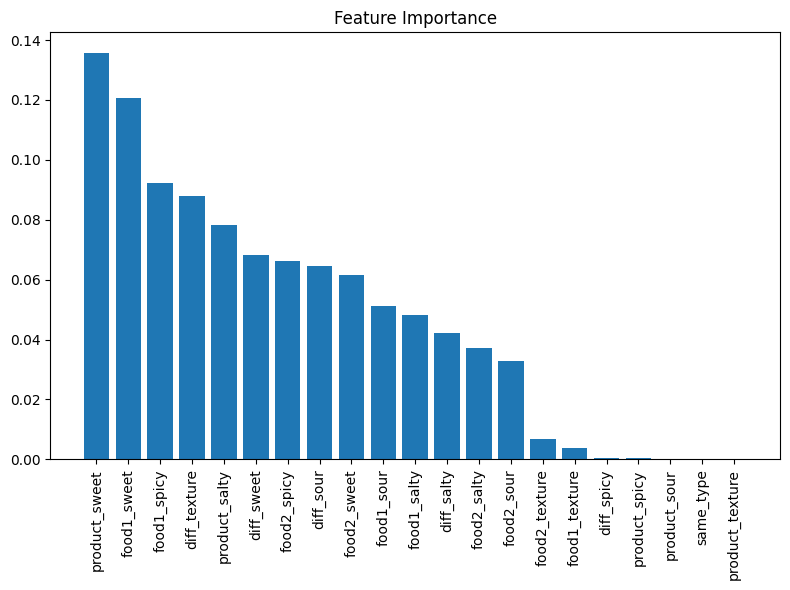

Feature importance plot saved as 'feature_importance.png'

Top 10 important features:
product_sweet: 0.1358
food1_sweet: 0.1208
food1_spicy: 0.0923
diff_texture: 0.0881
product_salty: 0.0783
diff_sweet: 0.0684
food2_spicy: 0.0662
diff_sour: 0.0646
food2_sweet: 0.0617
food1_sour: 0.0513


In [44]:
_plot_feature_importance(xg_model)

In [53]:
evaluate_model(xg_model,X_test, y_test)

Evaluation metrics:
MSE: 1.2497
R²: -0.1084
Accuracy (within 0.5): 30.00%
Accuracy (within 1.0): 40.00%


{'mse': 1.2497185468673706,
 'r2': -0.10839784145355225,
 'accuracy_within_0.5': np.float64(0.3),
 'accuracy_within_1.0': np.float64(0.4)}

### RANDOM FOREST

Training random_forest model with grid search...
Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Test MSE: 1.3832
Test R²: -0.2268


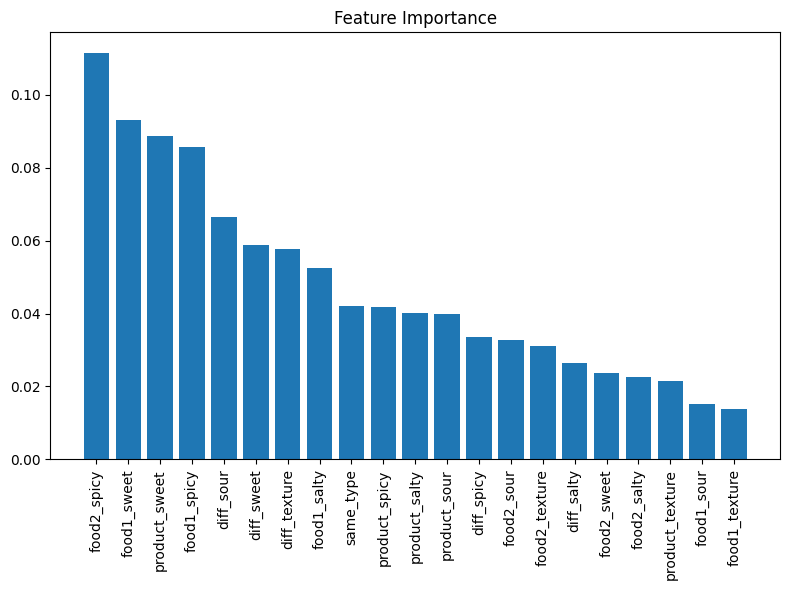

Feature importance plot saved as 'feature_importance.png'

Top 10 important features:
food2_spicy: 0.1115
food1_sweet: 0.0932
product_sweet: 0.0887
food1_spicy: 0.0857
diff_sour: 0.0665
diff_sweet: 0.0589
diff_texture: 0.0578
food1_salty: 0.0526
same_type: 0.0421
product_spicy: 0.0419


In [46]:
rf_model = train_model(X,y, model_type='random_forest')
_plot_feature_importance(rf_model)

In [54]:
evaluate_model(rf_model,X_test, y_test)

Evaluation metrics:
MSE: 1.3832
R²: -0.2268
Accuracy (within 0.5): 25.00%
Accuracy (within 1.0): 45.00%


{'mse': 1.3832312034270426,
 'r2': -0.22681259727453873,
 'accuracy_within_0.5': np.float64(0.25),
 'accuracy_within_1.0': np.float64(0.45)}

## GRADIENT_BOOSTING

Training gradient_boosting model with grid search...
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Test MSE: 1.2237
Test R²: -0.0853


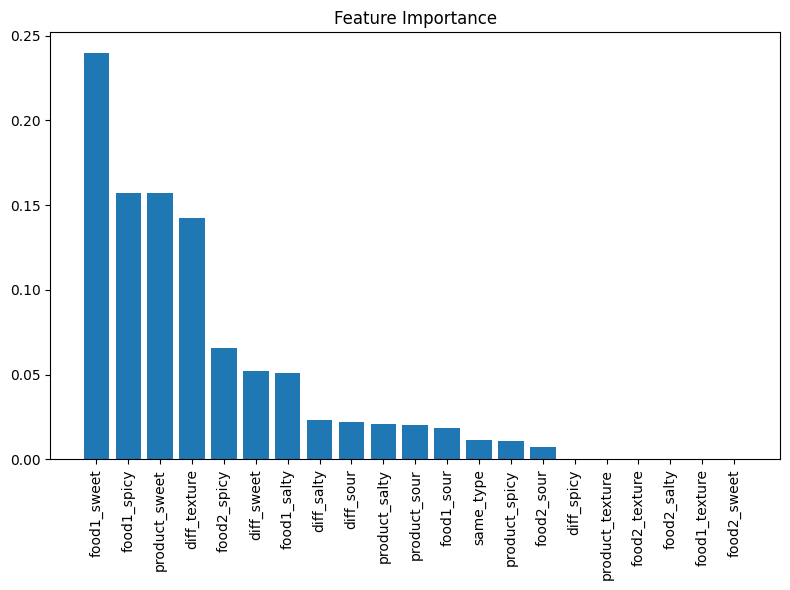

Feature importance plot saved as 'feature_importance.png'

Top 10 important features:
food1_sweet: 0.2400
food1_spicy: 0.1573
product_sweet: 0.1570
diff_texture: 0.1423
food2_spicy: 0.0656
diff_sweet: 0.0519
food1_salty: 0.0507
diff_salty: 0.0232
diff_sour: 0.0222
product_salty: 0.0212


In [47]:
gb_model = train_model(X,y, model_type='gradient_boosting')
_plot_feature_importance(gb_model)

In [55]:
evaluate_model(gb_model,X_test, y_test)

Evaluation metrics:
MSE: 1.2237
R²: -0.0853
Accuracy (within 0.5): 35.00%
Accuracy (within 1.0): 50.00%


{'mse': 1.223665242221597,
 'r2': -0.08529068046261346,
 'accuracy_within_0.5': np.float64(0.35),
 'accuracy_within_1.0': np.float64(0.5)}

### NEURAL NETWORK

In [48]:
nn_model = train_model(X,y, model_type='neural_network')
_plot_feature_importance(nn_model)

Training neural_network model with grid search...
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50)}
Test MSE: 1.5657
Test R²: -0.3887


In [56]:
evaluate_model(nn_model,X_test, y_test)

Evaluation metrics:
MSE: 1.5657
R²: -0.3887
Accuracy (within 0.5): 20.00%
Accuracy (within 1.0): 35.00%


{'mse': 1.5657473012975438,
 'r2': -0.38868940248119155,
 'accuracy_within_0.5': np.float64(0.2),
 'accuracy_within_1.0': np.float64(0.35)}

In [ ]:
def predict(model, food1_features, food2_features, food1_type=None, food2_type=None):
    if model is None:
        raise ValueError("Model not trained yet. Call train_model first.")

    # Convert inputs to numpy arrays
    food1_features = np.array(food1_features)
    food2_features = np.array(food2_features)

    # Calculate difference and product features
    diff = np.abs(food1_features - food2_features)
    product = food1_features * food2_features

    # Set same_type feature
    same_type = 1 if food1_type == food2_type else 0

    # Combine features
    features = np.concatenate([
        food1_features,
        food2_features,
        diff,
        product,
        [same_type]
    ]).reshape(1, -1)

    # Scale features
    features_scaled = scaler.transform(features)

    # Predict
    prediction = model.predict(features_scaled)[0]

    # Ensure prediction is within valid range
    prediction = max(1, min(5, prediction))

    return prediction

In [ ]:
def predict_from_names(model, food1_name, food2_name, food_data):

    food1_profile = food_data[food_data['name'] == food1_name]
    food2_profile = food_data[food_data['name'] == food2_name]

    if len(food1_profile) == 0:
        raise ValueError(f"Food '{food1_name}' not found in food data")
    if len(food2_profile) == 0:
        raise ValueError(f"Food '{food2_name}' not found in food data")

    food1_profile = food1_profile.iloc[0]
    food2_profile = food2_profile.iloc[0]

    flavor_cols = ['spicy', 'sweet', 'sour', 'salty', 'texture']
    food1_features = food1_profile[flavor_cols].values
    food2_features = food2_profile[flavor_cols].values

    food1_type = food1_profile['type']
    food2_type = food2_profile['type']

    return predict(model,food1_features, food2_features, food1_type, food2_type)

In [71]:
# Generate some food pairs for demonstration
food_pairs = [
    # Try different combinations: same type, different types
    ("น้ำมะนาว", "หมูแดดเดียว"),
    (food_data.iloc[2]['name'], food_data.iloc[22]['name']),
    (food_data.iloc[3]['name'], food_data.iloc[10]['name']),
]

best_model = gb_model
for food1_name, food2_name in food_pairs:
    try:
        prediction = predict_from_names(best_model,food1_name, food2_name, food_data)
        food1_type = food_data[food_data['name'] == food1_name].iloc[0]['type']
        food2_type = food_data[food_data['name'] == food2_name].iloc[0]['type']

        print(f"{food1_name} ({food1_type}) + {food2_name} ({food2_type}): {prediction:.2f}/5")
    except Exception as e:
        print(f"Error predicting {food1_name} + {food2_name}: {e}")



น้ำมะนาว (drink) + หมูแดดเดียว (snack): 2.78/5
ขนมจีบ (snack) + น้ำองุ่น (drink): 2.74/5
เกี๊ยวทอด (snack) + ซาลาเปา (snack): 2.40/5


In [79]:
def save_model_with_pickle(model, filename='model.pkl'):
    """
    Save a model using pickle.

    Parameters:
    -----------
    model : trained model object
        The trained model to save
    filename : str
        Path where the model will be saved
    """

    joblib.dump(model, 'model2.pkl')
    print(f"Model saved to {filename} using pickle")

In [80]:
save_model_with_pickle(best_model)

Model saved to model.pkl using pickle
